# Simulating membrane potential

<div class="admonition note">
**Topics**: Channels, Complexes, Voltage-dependant reactions.
</div>

This chapter introduces the concept of simulating the electric potential across a membrane in STEPS using a method that calculates electric potentials on tetrahedral meshes called 'E-Field' (see Hepburn I. et al. (2013) *Efficient calculation of the quasi-static electrical potential on a tetrahedral mesh. Front Comput Neurosci. DOI: 10.3389/fncom.2013.00129*).
We'll be introduced to new objects that represent phenomena linked to the membrane potential simulation, such as voltage-dependent channel transitions and currents across the membrane. We will look at an example based on a very widely-used model in computational neuroscience, the classical Hodgkin-Huxley model of the action-potential, in molecular form. To demonstrate some useful techniques for spatial simulations we will model action potential propagation in a simple mesh. As with previous chapters, we will briefly introduce the model, then go through Python code used to run the model in STEPS, with thorough descriptions where necessary.

We will start with spatial stochastic simulation in solvers `'Tetexact'`, then discuss what modifications are necessary to run the equivalent spatial deterministic solution in solver `'TetODE'`.

## Markov gating scheme

While many readers may not be familiar with conversion of the classical Hodgkin-Huxley (HH) model to a Markov gating scheme we will only give a brief description here, though there are many sources a reader may consult for a more detailed description (for example Hille B. *Gating Mechanisms: Kinetic Thinking. In Ion Channels of Excitable Membranes, 3rd ed. Sinauer Associates, Sunderland, MA: 2001:583-589*).
In brief, conductances are converted to a population of individual channels (each with single-channel conductance of typically 20pS), and each individual channel may exist in one of a number of states with rates described of possible first-order transitions to other states. Certain assumptions, such as that the the rate constants do not depend on the history of the system (a Markov process), and with the simplification that states with the same number of 'open' and 'closed' gates behave
identically regardless of specific configuration, lead to gating schemes as shown in the figure below for the HH potassium and sodium channels respectively.

<img src="images/channels_states.png"/>

Let us first focus on the top row of the figure. In this representation the potassium channel is described by 4 gates which may be in open or closed configuration. State n3, for example, means that any 3 of the 4 gates are in open state. Where all 4 gates are open (state n4, grey) the channel may conduct a current; all other states are non-conducting states. The sodium channel is represented by 8 possible states- the m3h1 state is the conducting state.

If we reuse the same type of graphical notation that we used in the [previous chapter](STEPS_Tutorial_Complexes.ipynb), it becomes apparent that the states of these gating schemes map to the states of complexes with `NoOrdering`.

Below the markov chains, we represented the full reaction networks when considering that the channels are made up of 4 subunits: 4 identical subunits that can be in closed ('c', light blue) or open ('o', dark blue) states for the K+ channel; 3 identical subunits that can be in closed (c, light orange) or open ('o', dark orange) states as well as one subunit that can be in inactivated ('i', light green) or activated ('a', dark green) states.
The markov chains from the top row are resulting from the grouping of equivalent channel substates. For the K+ channel, state n0 in the markov chain corresponds to only one channel state in which all subunits are in closed state; there are thus 4 ways to go to state n1 in which one of the subunits becomes open, and this is why the markov transition from n0 to n1 is done with a $4a_n$ rate.
The full reaction networks directly result from the application of the reactions over single subunits represented in the bottom row of the figure. K+ subunits can switch between closed and open states with respective rates $a_n$ and $b_n$. The same type of reactions apply to Na+ 'm' and 'h' subunits.

The transition rates ($a_n$, $b_n$  for the potassium channel - $a_m$, $b_m$, $a_h$, $b_h$ for the sodium channel) should be very familiar to anyone well-acquainted with the HH model:

\begin{equation}
a_n = \frac{0.01\times(10-(V+65))}{\exp\left(\frac{10-(V+65)}{10}\right)-1}
\end{equation}

\begin{equation}
b_n = 0.125\exp\left(\frac{-(V+65)}{80}\right)
\end{equation}

\begin{equation}
a_m = \frac{0.1\times(25-(V+65))}{\exp\left(\frac{25-(V+65)}{10}\right)-1}
\end{equation}

\begin{equation}
b_m = 4\exp\left(\frac{-(V+65)}{18}\right)
\end{equation}

\begin{equation}
a_h = 0.07\exp\left(\frac{-(V+65)}{20}\right)
\end{equation}

\begin{equation}
b_h = \frac{1}{\exp\left(\frac{30-(V+65)}{10}\right)+1}
\end{equation}

Where V is the potential across the membrane (in millivolts). Modelled as a stochastic process where each state is discretely populated, these functions form the basis of the propensity functions for each possible transition at any given voltage (here units are per millisecond). Voltage continuously changes during simulation, yet over a short period of time the change is small enough so that the transition rates may be considered constant and stochastic algorithms applied. The transition rates must then be updated when the voltage change becomes large enough to merit a reevaluation of these functions.

## Parameters and HH rate functions

We first import the required modules:

In [1]:
import steps.interface

from steps.model import *
from steps.geom import *
from steps.sim import *
from steps.saving import *
from steps.rng import *

import numpy as np
import math

Next we define some parameters for the simulation, which are intended to remain constant throughout the script. We start with the potassium channel and define the single-channel conductance, channel density and reversal potential, keeping to a conductance to 0.036 S/cm2.

In [2]:
# Potassium conductance = 0.036 S/cm2

# Potassium single-channel conductance
K_G = 20.0e-12 # Siemens

# Potassium channel density
K_ro = 18.0e12 # per square meter

# Potassium reversal potential
K_rev = -77e-3 # volts

The first thing to note is that, as usual in STEPS, units are s.i., which means in the above example the single channel conductance is given in Siemens and the reversal potential for the ohmic current is in volts.

Similarly, we define parameters for the sodium channel, also choosing a single-channel conductance of 20pS:

In [3]:
# Sodium conductance = 0.120 S/cm2

# Sodium single-channel conductance
Na_G = 20.0e-12 # Siemens

# Sodium channel density
Na_ro = 60.0e12 # per square meter

# Sodium reversal potential
Na_rev = 50e-3 # volts

The HH model also includes a leak conductance, which may also be discretised. The overall conductance is
small compared to maximal potassium and sodium conductances, but we choose a similar channel density to give
a good spatial spread of the conductance, which means a fairly low single-channel conductance:

In [4]:
# Leak single-channel conductance
L_G = 0.3e-12 # Siemens

# Leak density
L_ro = 10.0e12 # per square meter

# Leak reveral potential
leak_rev = -54.4e-3 # volts

The next parameters require a little explanation. Taking the potassium conductance as an example, the
potassium density will convert to a discrete number of channels that will give (approximately) our intended
maximal conductance of 0.036 S/$cm^2$. In the molecular sense, this means that if all potassium channels
are in the 'open' conducting state then we will reach the maximal conductance. However, in fact
each individual channel can be in any one of 5 states (including the conducting state) (see figure above) and the sum of populations of each state should
be equal to the total number of channels. For example, if the surface of the mesh is 100 square microns
by the above density we expect to have a total of 1800 potassium channels in the simulation but at some time
we might have e.g. 400 in the n0 state, 700 in the n1 state, 500 in the n2 state, 150 in the n3 state
and 50 in the conducting n4 state, and the total at any time will be equal to 1800.

So we intend to initialise our populations of channel states to some starting value. The details of how to
calculate the initial condition will not be given here, but the factors used here are steady-state approximations for
the HH model at an initial potential of -65mV. We then give a table of fractional channel state populations (which
add up to a value of 1). For each channel state the factor multiplied by the channel density and the surface area
of the mesh will give our initial population of channels in that state:

In [5]:
# A table of potassium channel population factors: 
# n0, n1, n2, n3, n4
K_facs = [ 0.21768, 0.40513, 0.28093, 0.08647, 0.00979 ]

# A table of sodium channel population factors
# m0h0, m1h0, m2h0, m3h0, m0h1, m1h1, m2h1, m3h1:
Na_facs = [[0.34412, 0.05733, 0.00327, 6.0e-05],
           [0.50558, 0.08504, 0.00449, 0.00010]]

We now define some more important parameters for our simulation. The first is temperature assumed for
the gating kinetics, which we will give in units of degrees celsius but is not directly used in simulation
(as we will see). The second is a current clamp that we intend for one end of the mesh. The third is a
voltage-range for simulation. These parameters will all be discussed in more detail later:

In [6]:
# Temperature for gating kinetics
celsius = 20.0

# Current injection
Iclamp = 50.0e-12 #	amps

# Voltage range for gating kinetics in Volts
Vrange = [-100.0e-3, 50e-3, 1e-4]

Next we will declare a function that computes the HH transition rates in a standardized form. Each of the equations shown above can be modified to fit the following generic form (see Nelson ME (2005) *Electrophysiological Models In: Databasing the Brain: From Data to Knowledge. (S. Koslow and S. Subramaniam, eds.) Wiley, New York, pp. 285–301*):

\begin{equation}
\frac{A + B \times V}{C + H \times \exp\left(\frac{V + D}{F}\right)}
\end{equation}

We thus implement the following function:

In [7]:
def HHRateFunction(A, B, C, D, F, H, V):
    num = A + B * V
    denom = C + H * math.exp((V + D) / F)
    if num == denom == 0:
        return F * B / (H * math.exp((V + D) / F))
    else:
        return num / denom

Note that, under certain conditions, both the numerator and the denominator can go to zero for some specific membrane potential. In this case, we use [L'Hôpital's rule](https://en.wikipedia.org/wiki/L'H%C3%B4pital's_rule) to return a meaningful value.

Finally we set some simulation control parameters, the 'time-step' at which we will record data and the total time of the simulation. So we will run for 4ms and save data every 0.1ms:

In [8]:
# The simulation dt
DT_sim = 1.0e-4 # seconds

# The time until which the simulation should be run
ENDT = 4.0e-3

## Model declaration

We move on to the biochemical model description. This is quite different from previous chapters, with new objects to look at, which are important building blocks of any simulation that includes voltage-dependent processes in STEPS.

To make our potassium, sodium and leak channels we need to use a new class: the [steps.model.Channel](API_model.rst#steps.API_2.model.Channel) class. This class inherits from [steps.model.Complex](API_model.rst#steps.API_2.model.Complex) so channels behave in the same way as complexes (see [previous chapter](STEPS_Tutorial_Complexes.ipynb)); the main difference lies in `Channel`s being able to conduct currents across membranes.

### Channel declaration

As we saw with the first figure, both potassium and sodium channels are described with a markov chain and, while we could describe each state explicitely, we will instead take advantage of the fact that the `Channel` class inherits from `Complex`. We will thus create potassium channels with 4 identical subunits being in either open or closed state, and sodium channels with 3 identical *m* subunits and one *h* subunit each of which can also only be in two states. As we saw in the [multi-state complexes chapter](STEPS_Tutorial_Complexes.ipynb), these declarations will yield the states that are represented in the top row of the first figure.

We then proceed to declaring the `Channel`s, their associated `SubUnit`s and `SubUnitState`s:

In [9]:
model = Model()

r = ReactionManager()

with model:
    ssys = SurfaceSystem.Create()

    #  Potassium channel
    Ko, Kc = SubUnitState.Create()
    KSU = SubUnit.Create([Ko, Kc])
    VGKC = Channel.Create([KSU]*4)

    # Sodium channel
    Na_mo, Na_mc, Na_hi, Na_ha = SubUnitState.Create()
    NamSU, NahSU = SubUnit.Create(
        [Na_mo, Na_mc],
        [Na_hi, Na_ha]
    )
    VGNaC = Channel.Create([NamSU, NamSU, NamSU, NahSU])

    # Leak channel
    lsus = SubUnitState.Create()
    Leak = Channel.Create([lsus])

The leak channel can only be in a single state but still needs to have an associated `SubUnitState`. It is however possible to skip declaring a `SubUnit` by giving the `SubUnitState` directly to the `Channel` constructor. Note that we declared a surface system since voltage dependent reactions are going to happen on the cell membrane. 

### Voltage dependent reactions declaration

We move on to describing the transitions between channel states. Instead of declaring all the reactions from the markov chain, we only declare the subunit reactions from the bottom row of the first figure. STEPS will automatically compute the required channel states and apply the required coefficients for the reaction rates.

All these reactions are voltage-dependent, the declaration of the rection themselves are the same as for normal reactions but instead of setting the `K` rate constant property to a specific number, we will set it to a `VDepRate` object (see [steps.model.VDepRate](API_model.rst#steps.API_2.model.VDepRate)).

Note however that, since the voltage is always defined with respect to a membrane, STEPS does not support voltage-dependent reactions for volume systems, only for surface systems.

We introduce temperature dependence and use the previously defined `celsius` variable to find `thi` at 20 degrees celsius:

In [10]:
thi = math.pow(3.0, ((celsius-6.3)/10.0))

_a_n = VDepRate(
    lambda V: thi * 1e3 * HHRateFunction(-0.55, -0.01, -1, 55, -10, 1, V*1e3),
    vrange=Vrange
)
_b_n = VDepRate(
    lambda V: thi * 1e3 * HHRateFunction(1, 0, 0, 65, 80, 8, V*1e3),
    vrange=Vrange
)

_a_m = VDepRate(
    lambda V: thi * 1e3 * HHRateFunction(-4, -0.1, -1, 40, -10, 1, V*1e3),
    vrange=Vrange
)
_b_m = VDepRate(
    lambda V: thi * 1e3 * HHRateFunction(1, 0, 0, 65, 18, 0.25, V*1e3),
    vrange=Vrange
)

_a_h = VDepRate(
    lambda V: thi * 1e3 * HHRateFunction(1, 0, 0, 65, 20, 1 / 0.07, V*1e3),
    vrange=Vrange
)
_b_h = VDepRate(
    lambda V: thi * 1e3 * HHRateFunction(1, 0, 1, 35, -10, 1, V*1e3),
    vrange=Vrange
)

We first declare voltage dependent rates with the `VDepRate` class. Its constructor takes a function as first parameter and an optional voltage range (with the `vrange` parameter). The function must take a voltage in Volts as a parameter and return a reaction rate constant in S.I. units. Here the rates correspond to the classical HH rates. 
`HHRateFunction` expects a voltage to be given in units of millivolts, and will return the transition rate in unit of /ms, so we apply the required conversions to get rate constants in S.I. units.

Note that any callable function with one argument would be valid here but we chose to use lambda expressions for concision.

The `vrange` argument is the voltage-range in which to evaluate the rate-function. It should be given as a Python list of length 3 with, in order: the minimum voltage, the maximum voltage, and the voltage-step. We should choose the voltage range to cover what we expect from the simulation, but not by too much since a smaller range gives faster performance, and the voltage-step should be chosen to give only a small error from linear interpolation between voltage-points. It is a very important point because if, during a simulation, the membrane potential goes outside the voltage range for any voltage-dependent reaction located in that membrane, the simulation will fail.
In our example we choose a voltage range of -100mV to +50mV, and tell STEPS to evaluate the voltage every 0.1mV (`Vrange` was declared earlier, with other parameters).

We then declare all reactions with:

In [11]:
with model:
    with ssys:
        with VGKC[...]:
            Kc.s <r[1]> Ko.s
            r[1].K = _a_n, _b_n

        with VGNaC[...]:
            Na_hi.s <r[1]> Na_ha.s
            r[1].K = _a_h, _b_h
            
            Na_mc.s <r[1]> Na_mo.s
            r[1].K = _a_m, _b_m

Note that if we decided to declare n0, n1, etc. states explicitely, we could have declared reactions in the following way:

```python
...
n0.s <r[1]> n1.s
r[1].K = 4*_a_n, _b_n
...
```
We would not need to declare a new `VDepRate` object, we can simply directly multiply the existing one with the appropriate coefficient.

Since we are declaring reactions between `SubUnitState`s, we first need to specify the `Channel` to which these reactions apply and the state in which this channel must be for the reaction to apply. Since our reactions always apply regardless of the channel state we use e.g.:
```python
with VGKC[...]:
    Kc.s <r[1]> Ko.s
    r[1].K = _a_n, _b_n
```
Since the reaction happens on the membrane, we need to specify the Channel position by adding the `.s` after the `SubUnitState`. If the state of the channel affected the voltage dependency of the reaction rates, we could have written:
```python
with VGKC[Ko, Ko, ...]:
    Kc.s <r[1]> Ko.s
    r[1].K = _a_n_2, _b_n_2
```
With this code, we only declare reactions for channels that have at least two subunits in the open state, and we use a different reaction rate.

### Current declaration

The final part of our model specification is to add currents. Presently in STEPS we have the choice of two types of current that have quite different behaviour: Ohmic currents- which are represented by [steps.model.OhmicCurr](API_model.rst#steps.API_2.model.OhmicCurr) objects- and currents based on the GHK flux equation- represented by [steps.model.GHKCurr](API_model.rst#steps.API_2.model.GHKCurr) objects. Since the Hodgkin-Huxley model utilises ohmic currents we only need to concern ourselves with those objects here.

The assumption made in STEPS is that Ohmic current objects are used to model currents of ions that play no other important role in the system other than in membrane excitability, and so it is not necessary to add, in this example, ions of sodium and potassium diffusing both extra- and intra-cellularly. Because of the relatively large concentration of these ions simulating diffusion would be incredibly slowing to simulations with no perceptible benefit to accuracy. It is due to these arguments that an Ohmic current in STEPS will not result in transport of ions between compartments. The GHK current objects are able to model ion transport and so should always be used when modelling currents of important signalling ions, a good example of which for many systems is calcium.

Because STEPS is primarily a discrete simulator the Current objects in STEPS are based on single-channel currents. A [steps.model.OhmicCurr](API_model.rst#steps.API_2.model.OhmicCurr) is linked to one or several `ComplexState` of the `Channel` and will result in an Ohmic current through every single Channel in that specific state located in the Membrane (which we will create later) at any given time. Therefore, to create an ohmic current in STEPS we need to pass information as to which Channel state the current will be applied to, as well as its single-channel conductance to this current, along with the reversal potential. As usual in STEPS all units are based on s.i. units, and so the single-channel conductance unit is Siemens and reversal potential unit is volts.

The [steps.model.OhmicCurr](API_model.rst#steps.API_2.model.OhmicCurr) objects need to be created inside a `with ssys:` block and their constructor expects 3 arguments: a reference to a `ComplexState` or `ComplexSelector` specifying the state(s) to which this current applies, a single-channel conductance, and a reversal potential. At the top of our script we already defined conductance and reversal potential for all of our channels in this simulation, i.e. the potassium single-channel conductance ``K_G = 20.0e-12`` Siemens and reversal potential ``K_rev = -77e-3`` volts, the sodium single-channel conductance ``Na_G = 20.0e-12`` Siemens and reversal potential ``Na_rev = 50e-3`` volts, the leak single-channel conductance ``L_G = 0.3e-12`` Siemens and reversal potential ``leak_rev = -54.4e-3`` volts, so we use these values when creating the Ohmic current objects. The conducting states of the potassium, sodium and leak currents respectively are `VGKC[Ko, Ko, Ko, Ko]` (which corresponds to `K_n4` on the markov chain), `VGNaC[Na_mo, Na_mo, Na_mo, Na_ha]` (which corresponds to `Na_m3h1`) and `Leak[lsus]` (which is the only state of the leak channel):

In [12]:
with model:
    with ssys:
        VGKC_I = OhmicCurr.Create(VGKC[Ko, Ko, Ko, Ko], K_G, K_rev)
        VGNaC_I = OhmicCurr.Create(VGNaC[Na_mo, Na_mo, Na_mo, Na_ha], Na_G, Na_rev)
        Leak_I = OhmicCurr.Create(Leak[lsus], L_G, leak_rev)

As this guide uses jupyter notebook, we need to rewrite both context managers `with model:` and `with ssys:`, but in a normal python script, we would declare the currents in the same `with ssys:` block as the one in which we declared the reactions. Note that you can also group them in a single context manager `with model, ssys:`.

`VGKC[Ko, Ko, Ko, Ko]` reprensents the K+ channel state in which all 4 subunits are in the open state. Note that it is possible to give a partially specified channel state as first parameter of the current constructor. For example, if we wanted to consider that the K+ channel is open if at least 3 subunits are in the open state, we could have written:
```python
VGKC_I = OhmicCurr.Create(VGKC[Ko, Ko, Ko, :], K_G, K_rev)
```
Note that, since all subunits are identical for the K+ channel, the position of the `:` does not matter as `Channel`s do not take `SubUnit` order into account by default, see the [documentation](API_model.rst#steps.API_2.model.Complex) for details.

#### State dependent conductances

Instead of giving a constant conductance, as we did in the main example, we could give a conductance that depends on the channel state:
```python
...
K_conds = [0, 0.05*K_G, 0.1*K_G, 0.5*K_G, K_G]
K_depG = CompDepCond(lambda s: K_conds[s.Count(Ko)], [VGKC])

VGKC_I = OhmicCurr.Create(VGKC[Ko, ...], K_depG, K_rev)
```
We declare a `Complex` dependent conductance with the`CompDepCond` constructor. The first parameter is a function that takes a `ComplexState` as argument and outputs a conductance; the second argument is a list of complexes (channels here) that specifies on which complexes will the conductance depend. Here we only depend on the state of the K+ channel. 

In the lambda function, we call the `Count` method on the channel state `s` in order to count the number of subunits that are in open state `Ko`, we then use this number to find the corresponding conductance in a small list that we declared just before: 1 open subunit corresponds to 5% of the maximum conductance, 2 open to 10%, 3 open to 50% and 4 open to the maximum conductance. 

The current is then created by specifying that it applies to all K+ channel states that have at least one open subunit. We could have applied it to all states but it would result in null currents since the conductance associated to all subunits being closed is 0. Note that when the first parameter of the current constructor corresponds to more than one channel state, several subcurrents are created and associated to the same current name (`'VGKC_I'` here). When saving data, these subcurrents can be accessed by specifying the state of the channel they correspond to, as we will see later.

#### GHK currents

Although we do not use GHK currents in the main example, we will quickly go over how to declare them. Assuming we want to declare a GHK Na+ current, we would have to write:
```python
with mdl:
    Na = Species.Create()
    Na.valence = 1
    
    with ssys:
        VGNaC_I = GHKCurr.Create(VGNaC[Na_mo, Na_mo, Na_mo, Na_ha], Na, VGNaC_P)
```
The current is created with the `GHKCurr` class that takes the conducting state(s) as first parameter, like for `OhmicCurr`, but then takes the ion for which the current is defined followed by the permeability of the channel (`VGNaC_P` here).
Note that this permeability can be obtained with the `GHKCurr.PInfo` [class method](API_model.rst#steps.API_2.model.GHKCurr.PInfo).

Like for conductances, it is possible to define state-dependent permeabilities:
```python
Na_perm = [0, 0.05*VGNaC_P, 0.5*VGNaC_P, VGNaC_P]
Na_depP = CompDepP(lambda s: Na_perm[s.Count(Na_mo)], [VGNaC])
VGNaC_I = GHKCurr.Create(VGNaC[Na_mo, ..., Na_ha], Na, Na_depP)
```
More details can be found in the `GHKCurr` [documentation](API_model.rst#steps.API_2.model.GHKCurr).

## Geometry declaration

Coming back to our main example, with the model completed we move on to geometry specification. To simulate action potential propagation we will demonstrate the rather unusual case of using a long cuboid mesh whereas other simulators may typically assume cylindrical geometry. This is partly to demonstrate that the only restriction on geometry used for the membrane potential calculation in STEPS is that it can be represented by a tetrahedral mesh. Since tetrahedral meshes are capable of representing real cellular geometry with high accuracy this opens up many interesting applications, yet for this example we will stick with a rather basic shape. As in previous sections we will import a mesh in Abaqus format, which represents a cuboid of length 1000µm in the z-axis, and a diameter of 0.44µm (which is an equivalent cylindrical diamter of 0.5µm) in the x and y axes:

In [13]:
mesh = TetMesh.LoadAbaqus('meshes/axon.inp', scale=1e-6)

We then compute some element lists that will be used later:

In [14]:
with mesh:
    facetris = TriList([tri for tri in mesh.tris if tri.center.z == mesh.bbox.min.z])
    injverts = facetris.verts

    memb_tris = mesh.surface - facetris

    # The points along (z) axis at which to record potential
    pot_pos = np.arange(mesh.bbox.min.z, mesh.bbox.max.z, 10e-6)
    pot_tet = TetList(mesh.tets[0, 0, z] for z in pot_pos)

We first create a list (`facetris`) of the triangles that are on one of the ends of the axon (that is oriented along the z-axis) and extract the corresponding vertices with `facetris.verts`. We will use these vertices to inject current in the axon. The triangles in the membrane are all triangles in the mesh surface except the ones that are on the injection face. Finally, we declare a list of regularly spaced tetrahedrons along the axon that we will record potential from.

We then declare the needed compartment, patch, and membrane for potential computation:

In [15]:
with mesh:
    cyto = Compartment.Create(mesh.tets)
    patch = Patch.Create(memb_tris, cyto, None, ssys)

    # Create the membrane across which the potential will be solved
    membrane = Membrane.Create([patch])

The last line creates a new and very important object for the membrane potential calculation, the 'membrane' itself. The membrane class, [steps.geom.Membrane](API_geom.rst#steps.API_2.geom.Membrane), simply consists of one or more patch objects which must together form one continuous surface, although the membrane may be 'open' or 'closed' ('closed' means all member triangles are directly connected to 3 other membrane triangles and so form a closed surface, and 'open' means some triangles have fewer than 3 neighbours and so the surface contains holes). Any channels that exist in the patch(es) that comprise(s) the membrane are available to conduct a current (specified by [steps.model.OhmicCurr](API_model.rst#steps.API_2.model.OhmicCurr) or [steps.model.GHKCurr](API_model.rst#steps.API_2.model.GHKCurr) objects). The INNER compartment(s) to the membrane patches will comprise the 'conduction volume' representing the intracellular region. The potential at all vertices in the membrane and conduction volume will be calculated and will vary with any channel, capacitive or externally applied currents, relative to the (earthed) extracellular region.

Where the extracellular space is included in simulations the membrane may be comprised of internal mesh triangles, but for this relatively simple model the membrane is formed from triangles on the surface of the mesh and is comprised of only one patch. This patch contains an inner compartment consisting of all tetrahedrons in the mesh, which will form the conduction volume. 

The [steps.geom.Membrane](API_geom.rst#steps.API_2.geom.Membrane) constructor optionally takes an argument named `opt_method`. This allows the choice of a method for optimization of the ordering of vertices in the membrane and conduction volume, which is essential to produce an efficient calculation, as discussed in Hepburn I. et al. (2013) *Efficient calculation of the quasi-static electrical potential on a tetrahedral mesh. Front Comput Neurosci. DOI: 10.3389/fncom.2013.00129*. Two methods are presently available: 1) a fast ordering of vertices by their position along the principle axis, which is suitable if one axis is much longer than an other (as is the case here) and 2) a slower breadth-first tree iteration, which produces a similar result to method (1) in cable-like structures but offers a significant improvement to simulation efficiency in complex geometries. Although the initial search for (2) can be slow it is possible to save an optimisation in a file for a specific membrane with `Simulation` method  [steps.sim.Simulation.saveMembOpt](API_sim.rst#steps.API_2.sim.Simulation.saveMembOpt), and this optimisation file can then be supplied as the `opt_file_name` argument to the membrane constructor, so each optimisation for any given membrane need only be found once. However, since this example uses a cable-like mesh we can use the faster principle-axis ordering method, though method (2) is recommended when working with complex, realistic geometries.

There is also an optional boolean argument `verify`, which defaults to False, but if True will verify that the membrane is a suitable surface for the potential calculation- although this verification can take rather a long time for larger meshes, so should only be used when one is not confident in the suitability of the membrane.

All membrane construction parameters are described in details in the [documentation](API_geom.rst#steps.API_2.geom.Membrane).

## Simulation and data saving

### Result selectors

We will use the `'Tetexact'` solver and save the K+ and Na+ currents across the membrane as well as the potential at the regularly spaced tetrahedrons we mentioned before:

In [16]:
rng = RNG('mt19937', 512, 1234)

sim = Simulation('Tetexact', model, mesh, rng, True)

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

rs = ResultSelector(sim)

NaCurrs = rs.TRIS(memb_tris).VGNaC_I.I
KCurrs = rs.TRIS(memb_tris).VGKC_I.I
CellPot = rs.TETS(pot_tet).V

NaCurrs.metaData['trizpos'] = [tri.center.z for tri in memb_tris]
KCurrs.metaData['trizpos'] = [tri.center.z for tri in memb_tris]

NaCurrs.metaData['triarea'] = [tri.Area for tri in memb_tris]
KCurrs.metaData['triarea'] = [tri.Area for tri in memb_tris]

CellPot.metaData['tetzpos'] = pot_pos

NaCurrs.toFile('NaCurrs.dat')
KCurrs.toFile('KCurrs.dat')
CellPot.toFile('CellPot.dat')

sim.toSave(NaCurrs, KCurrs, CellPot, dt=DT_sim)

Model checking:
No errors were found


Note that we pass an additional boolean flag to the `Simulation` constructor, it specifies whether membrane potential calculations should be performed. This flag defaults to `False` so we could omit it in previous chapters, but since we do need membrane potential computations, we need to set it to `True`.

Since the `VGNaC_I` and `VGKC_I` currents are both associated to a single channel state, the `NaCurrs` and `KCurrs` result selectors will save the current corresponding to this state for each triangle in `memb_tris`. If the currents were associated to several channel states, these same result selectors would save the sum of each subcurrent for each triangle. If one wanted to access a specific subcurrent one would write:
```python
rs.TRIS(memb_tris).VGKC_I[Ko, Ko, Ko, Kc].I
```
This result selector would only save the cubcurrent associated to K+ channels with 3 open subunits and one closed. In the same way, it is also possible to save the summed currents associated to several channel states:
```python
rs.TRIS(memb_tris).VGKC_I[Ko, Ko, ...].I
```
This would save the summed currents through all K+ channels that have at least two subunits in the open state. Finally, if one wants to save separately each subcurrent, one can write e.g.:
```python
rs.patch.LIST(*VGKC_I).I
```
Iterating over the `VGKC_I` current object returns the sub currents it is composed of.

Since we want to plot spatial current density profiles, we need to save the z position and area of membrane triangles as metadata. In the same way, we need to save the z position of the tetrahedrons from which we will record potential.
Finally, all our result selectors will be saved to files in order to separate data analysis from the simulation script.

### Initial state

#### Setting channel counts

We should first pause to look at how to specify conductance in STEPS models. Conductance in STEPS comes from [steps.model.OhmicCurr](API_model.rst#steps.API_2.model.OhmicCurr) objects, which provide a single-channel conductance that will be applied to any Channel State molecule to which that conductance is mapped. For example, recall in this model that we created an Ohmic Current called `VGKC_I` to represent the potassium current in the simulation, which will apply to Channel State `VGKC[Ko, Ko, Ko, Ko]`, with a single-channel conductance of 20 pS and reversal potential of -77mV.

The overall potassium conductance in the simulation at any time will be equal to the number of `VGKC[Ko, Ko, Ko, Ko]` Channel States in existence multiplied by the single-channel conductance, with a maximum conductance equal to the highest possible number of `VGKC[Ko, Ko, Ko, Ko]` Channel States (the total number of potassium channels).

Other simulators may use different methods from STEPS to specify conductance, and many modellers may be more comfortable working with conductance per unit area, so some care should be taken with the conversion for STEPS models. This typically involves multiplying conductance per unit area by the membrane area to find overall conductance, then injecting the correct amount of channels into the membrane in STEPS to represent this conductance, depending on the single-channel conductance. Since the conducting channels are discrete in STEPS there may be a small discrepancy from the continuous value.

Recall we have specified potassium channel density, ``K_ro``, as 18 per square micron and sodium channel density, ``Na_ro``, as 60 per square micron, previously in our script.
When multiplied by single-channel conductances it gives maximum potassium conductance of 0.036 Siemens per square cm and sodium conductance of 0.120 Siemens per square cm. So when injecting our channels in STEPS we simply need to multiply these densities by the surface area of the membrane to find the number to inject.

We thus start a new run and initialize the counts of our channel states with:

In [17]:
sim.newRun()

# Inject channels
surfarea = sim.patch.Area

for state in VGNaC:
    prop = Na_facs[state.Count(Na_ha)][state.Count(Na_mo)]
    sim.patch.VGNaC[state].Count = Na_ro * surfarea * prop

for state in VGKC:
    prop = K_facs[state.Count(Ko)]
    sim.patch.VGKC[state].Count = K_ro * surfarea * prop

sim.patch.Leak[lsus].Count = L_ro * surfarea

Note that we set the count of channels by using the `Na_facs` and `K_facs` arrays that contain the fractions of channels that should be in each state. `K_facs` is sorted such that the first element corresponds to the state in which all subunits are in the closed state and the last element corresponds to all subunits in open state. `Na_facs` contains two arrays, the first one corresponding to the `Na_hSU` subunit in state `Na_hi` and the second one corresponds to state `Na_ha`. The two arrays are organized like `K_facs` but for the `Na_mSU` subunit.

We iterate over all states of e.g. the K+ channel and retrieve its corresponding fraction with:
```python
for state in VGKC:
    prop = K_facs[state.Count(Ko)]
```
where `state.Count(Ko)` returns the number of subunits in state `Ko` that are in the channel `state`.

#### Specifying membrane and EField parameters

The next few lines of code set some important new simulation variables, all to do with the membranes potential calculation:

In [18]:
# Set dt for membrane potential calculation to 0.01ms
sim.EfieldDT = 1.0e-5

# Initialize potential to -65mV
sim.membrane.Potential = -65e-3

# Set capacitance of the membrane to 1 uF/cm^2 = 0.01 F/m^2
sim.membrane.Capac = 1.0e-2

# Set resistivity of the conduction volume to 100 ohm.cm = 1 ohm.meter
sim.membrane.VolRes = 1.0

The first line sets the time-step period for the potential calculation, specified in seconds. This tells STEPS how often to perform the 'E-Field' calculation to evaluate potential, and update any voltage-dependent processes in the simulation. The optimal value for this time-step will vary for different simulations, so some things should be kept in mind when making the choice. Firstly, the time-step should be short enough that the voltage change  occurring during each time-step is small and voltage can be assumed constant during each time-step for any voltage-dependent processes in the model. A large time-step may result in loss of accuracy. Secondly, the shorter the time-step the slower the simulation will be. Thirdly, the time-step must be shorter or equal to the simulation time-step (this is 0.1ms in our model) so that at least one membrane potential calculation can be carried out per simulation time-step. As a rough guide 0.01ms is usually highly accurate, and it is not recommended to exceed 0.1ms. So for this simulation we choose a calculation time-step of 0.01ms (which happens to be the default value).

The remaining lines respectively set the initial membrane potential (in Volts), the membrane capacity (in Farad per square meter), and the bulk resistivity of the volume enclosed by the membrane (in ohm meter).

#### Current injection

The last condition to set is something that will remain unchanged throughout our simulation in this example, which is a constant current injection at one end of the long cubic geometry. This will have an effect of inducing action potentials at the depolarised end, which will then propagate, and a constant current at the correct level will ensure a train of action potentials. In STEPS it is possible to inject current to any vertex in the conduction volume or any membrane triangle by setting their `IClamp` property with a simulation path: `sim.VERT(vert).IClamp = ...` or `sim.TRI(tri).IClamp = ...` (where current will be shared equally between its 3 nodes). Here, we have already found the vertices at one end of the geometry, the minimum z end, and stored them in the `injverts` `VertList`. We now wish to set the current clamp for each of these vertices as a share of the 50pA current we have already defined in variable `Iclamp`. **Note**: *STEPS maintains the convention that the effect of a positive applied current is to make potential more positive, which is the opposite signing convention to channel currents.*:

In [19]:
# Set the current clamp
sim.VERTS(injverts).IClamp = Iclamp/len(injverts)

We then run the simulation with:

In [20]:
# Run the simulation
sim.run(ENDT)

### Simulation with `TetODE`

Another option for spatial simulations is to use the deterministic solver `'TetODE'`. TetODE shares many similarities with Tetexact in terms of model and geometry construction operating on the same tetrahedral meshes, but solutions are deterministic. TetODE uses CVODE (https://computing.llnl.gov/projects/sundials/cvode) for solutions. Although solutions are therefore very different between solver Tetexact and TetODE, in terms of simulation construction there are only a few implementation differences.
Therefore, we can use almost the exact same code as already introduced to run a deterministic simulation, with a few changes highlighted below.

Nothing needs to change for the model and geometry descriptions, and we can go on to creating the TetODE solver simulation. As a deterministic solver, TetODE does not require a random number generator so that does not need to be created and can be omitted from the simulation construction step. To avoid ambiguity, the `calcMembPot` argument now needs to be given as a keyword argument while we could give it as a positional argument with Tetexact.

We thus create the simulation with:

In [21]:
sim = Simulation('TetODE', model, mesh, calcMembPot=True)

Model checking:
No errors were found


It is unfortunately not possible to record information about the spatial currents in TetODE (see [available simulation paths per solver](API_sim.rst#simulation-paths)), we thus remove anything to do with recording the Na+ and K+ currents, which only leaves electrical potential:

In [22]:
rs = ResultSelector(sim)

CellPot = rs.TETS(pot_tet).V

CellPot.metaData['tetzpos'] = pot_pos

CellPot.toFile('CellPotODE.dat')

sim.toSave(CellPot)

sim.newRun()

/home/jules/.local/lib/python3.10/site-packages/steps/API_2/sim.py:1480: UserWarning: Cannot reset a TetODE solver, a new run was started but the solver was not reset.
  warnings.warn(


Note that, this time, we do not supply a `dt` argument to `sim.toSave(...)`. Instead, for reasons we will explain later, we will manually tell STEPS when the data should be saved.
The call to `newRun()` displays a warning because `TetODE` does not reset the simulation upon a call to `newRun()`. This is not an issue as we will only run one simulation and the solver state is initialized upon creation of the simulation.

Setting the initial conditions is done in the same way as for Tetexact:

In [23]:
# Inject channels
surfarea = sim.patch.Area

for state in VGNaC:
    prop = Na_facs[state.Count(Na_ha)][state.Count(Na_mo)]
    sim.patch.VGNaC[state].Count = Na_ro * surfarea * prop

for state in VGKC:
    prop = K_facs[state.Count(Ko)]
    sim.patch.VGKC[state].Count = K_ro * surfarea * prop

sim.patch.Leak[lsus].Count = L_ro * surfarea

# Initialize potential to -65mV
sim.membrane.Potential = -65e-3

# Set capacitance of the membrane to 1 uF/cm^2 = 0.01 F/m^2
sim.membrane.Capac = 1.0e-2

# Set resistivity of the conduction volume to 100 ohm.cm = 1 ohm.meter
sim.membrane.VolRes = 1.0

# Set the current clamp
sim.VERTS(injverts).IClamp = Iclamp/len(injverts)

There is one important additions to the TetODE solver, the [steps.sim.Simulation.setTolerances](API_sim.rst#steps.API_2.sim.Simulation.setTolerances) method.
To understand what this function does requires a little background on how CVODE works. Although there will only be a brief explanation here, thorough descriptions
are available in CVODE documentation (https://sundials.readthedocs.io/en/latest/cvode/).

Solving STEPS models in CVODE requires supplying information of all the variables in a STEPS simulation at any time as a state vector to the CVODE solver. The variables in STEPS
are the molecular species, which have unique populations in individual mesh elements (tetrahedrons and triangles) meaning that the state vector can be rather large (number_volume_specs*number_tetrahedrons + number_surface_specs*number_triangles). STEPS must also supply a function that describes the rate of change of each of these variables with time depending on other variables in the system. CVODE then finds approximate solutions (here STEPS choses the recommended Adams-Moulton formulas with functional iteration) when the system advances in time.

To do this it takes a number of 'steps', each time estimating the local error and comparing to tolerance conditions: if the test fails, step size is reduced, and this is repeated until tolerance conditions are met. This means that there is a tradeoff between accuracy and simulation speed- with a high tolerance, steps sizes will be large and few steps will have to be taken to advance the simulation some amount of time though accuracy will be low, with low tolerance, steps sizes will be small so a large number of steps will be taken to advance the simulation although accuracy will be high. Therefore, the tolerance is an important consideration both for accuracy and efficiency.

STEPS users can control the tolerances with the [steps.sim.Simulation.setTolerances](API_sim.rst#steps.API_2.sim.Simulation.setTolerances) method. Two different types of tolerance are specified: relative tolerance and absolute tolerance, and in STEPS both are scalars. Relative tolerance controls relative errors so that e.g. $10^{-3}$  means that errors are controlled to 0.1% (and it is not recommended to go any higher than that). Absolute tolerances can be useful when any components of the vector approach very small numbers when relative error control becomes meaningless. The absolute values in the internal state vectors within TetODE are the (fractional) number of molecules per tetrahedron or triangle, so if a user specifies an absolute tolerance of $10^{-3}$  it means that populations within tetrahedrons and triangles will be accurate to within 1/1000th of a molecule! In TetODE only one value each for absolute tolerance and relative tolerance can be specified, and will be applied to all species in all locations in the system. The default value for both absolute tolerance and relative tolerance is $10^{-3}$.

We set tolerances with a call to [steps.sim.Simulation.setTolerances](API_sim.rst#steps.API_2.sim.Simulation.setTolerances):

In [24]:
sim.setTolerances(1e-3, 1e-4)

The first function argument is absolute tolerance, the second is relative tolerance. In this example we set an absolute tolerance of  $10^{-3}$  and relative tolerance of $10^{-4}$.

Note that the `setEfieldDT` method is not supported in TetODE: rather the E-Field time-step is implicitly taken as the simulation time step. E.g. one E-Field calculation will be performed every time the STEPS simulation
is advanced with a call to [steps.sim.Simulation.run](API_sim.rst#steps.API_2.sim.Simulation.run). Therefore, in this model, to achieve an E-Field calculation time-step of 0.01ms we need to split the simulation time ourselves with e.g.:

In [25]:
# Run the simulation
EFDt = 1e-5
for i in range(int(ENDT // EFDt) + 1):
    sim.run(i * EFDt)
    if i % 10 == 0:
        CellPot.save()

In Tetexact simulations, we saved data every 0.1 ms. To avoid potential issues when mixing automatic data saving and manual control of simulation steps, we explicitely save the data from `CellPot` every 10 iterations of the loop, i.e. every 0.1 ms. This is done by calling `CellPot.save()`.

Before proceeding to result plotting, we reset the jupyter notebook so that the remaining code will be executed as if it was run in a separate script:

In [26]:
%reset -f

## Plotting the results

We first import the required modules and define a function to plot the potential along the axon at a given time index `tidx`:

In [27]:
import steps.interface

from steps.saving import *

from matplotlib import pyplot as plt
import numpy as np

def plotPotential(CellPot, tidx):
    plt.plot(
        CellPot.metaData['tetzpos'] * 1e6, 
        CellPot.data[0, tidx, :] * 1e3, 
        label=f'{CellPot.time[0, tidx]*1e3} ms'
    )

The first argument will be the loaded `ResultSelector`. We then define another function to plot both K+ and Na+ current densities through the membrane along the axon:

In [28]:
def plotCurrents(NaCurrs, KCurrs, tidx, nbins=100):
    for results, currName in zip([NaCurrs, KCurrs], ['Na', 'K']):
        data = results.data[0, tidx, :] * 1e12
        pos = results.metaData['trizpos'] * 1e6
        areas = results.metaData['triarea'] * 1e12
        bins = np.histogram_bin_edges(pos, nbins)
        dig = np.digitize(pos, bins)
        # Ignore empty bins
        with np.errstate(invalid='ignore'):
            meanData = np.bincount(dig, weights=data) / np.bincount(dig, weights=areas)
            meanPos  = np.bincount(dig, weights=pos) / np.bincount(dig)
        plt.plot(meanPos, meanData, label=f'{currName} {results.time[0, tidx]*1e3} ms')

Since we recorded currents for each membrane triangle, we first need to bin the currents along the axon.
In order to simplify the code, we rely heavily on the numpy functions [histogram_bin_edges](https://numpy.org/doc/stable/reference/generated/numpy.histogram_bin_edges.html), [digitize](https://numpy.org/doc/stable/reference/generated/numpy.digitize.html), and [bincount](https://numpy.org/doc/stable/reference/generated/numpy.bincount.html).
We first create bin edges for the triangle positions with:
```python
bins = np.histogram_bin_edges(pos, nbins)
```
We then assign each triangle to its bin with:
```python
dig = np.digitize(pos, bins)
```
Finally, we compute current densities and average bin position with:
```python
meanData = np.bincount(dig, weights=data) / np.bincount(dig, weights=areas)
meanPos  = np.bincount(dig, weights=pos) / np.bincount(dig)
```
Note that `np.bincount(dig)` returns the number of triangles in each bin while `np.bincount(dig, weights=areas)` returns the summed areas of triangles in each bin.

### Tetexact simulation

Finally, we load the corresponding result selector from file and plot the potential along the axon at different time steps:

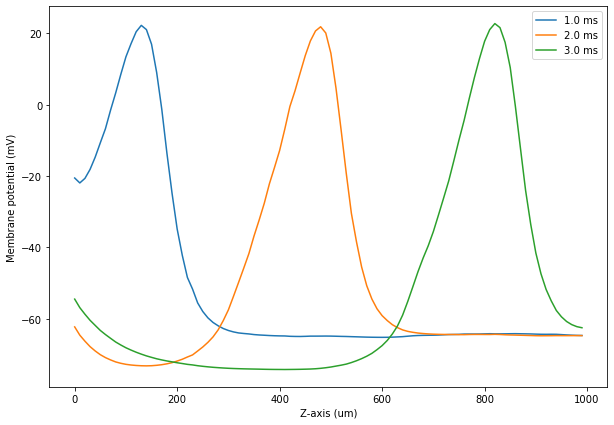

In [29]:
CellPot = ResultSelector.FromFile('CellPot.dat')

plt.figure(figsize=(10, 7))
plotPotential(CellPot, 10)
plotPotential(CellPot, 20)
plotPotential(CellPot, 30)
plt.xlabel('Z-axis (um)')
plt.ylabel('Membrane potential (mV)')
plt.legend()
plt.show()

We then plot the Na+ and K+ current densities along the axon for the same time steps:

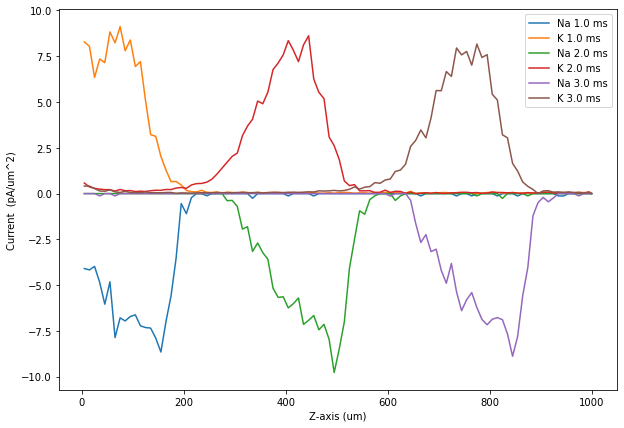

In [30]:
NaCurrs = ResultSelector.FromFile('NaCurrs.dat')
KCurrs = ResultSelector.FromFile('KCurrs.dat')

plt.figure(figsize=(10, 7))
plotCurrents(NaCurrs, KCurrs, 10)
plotCurrents(NaCurrs, KCurrs, 20)
plotCurrents(NaCurrs, KCurrs, 30)
plt.xlabel('Z-axis (um)')
plt.ylabel('Current  (pA/um^2)')
plt.legend()
plt.show()

### TetODE Simulation

We now plot the potential along the axon for the `'TetODE'` simulation.

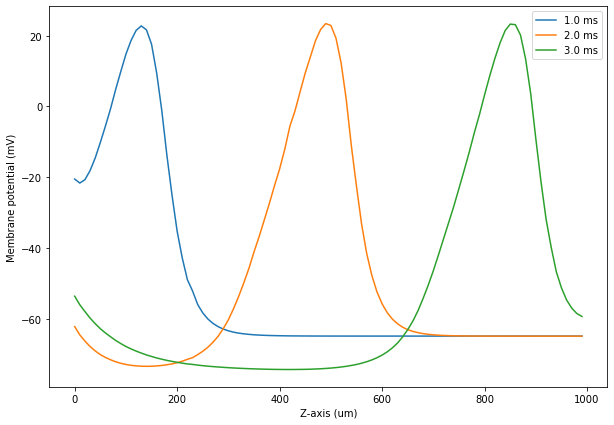

In [31]:
CellPotODE = ResultSelector.FromFile('CellPotODE.dat')

plt.figure(figsize=(10, 7))
plotPotential(CellPotODE, 10)
plotPotential(CellPotODE, 20)
plotPotential(CellPotODE, 30)
plt.xlabel('Z-axis (um)')
plt.ylabel('Membrane potential (mV)')
plt.legend()
plt.show()